In [122]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import argparse
import matplotlib.pyplot as plt


def get_dataset(n_samples=100000):
    from sklearn.datasets import make_swiss_roll
    
    x = make_swiss_roll(n_samples=n_samples, noise=0.05)[0][:,[0, 2]]
    
    class ToyDataset(torch.utils.data.Dataset):
        def __init__(self, x):
            xmin, xmax = x.min(axis=0)[0], x.max(axis=0)[0]
            x = (x - xmin) / (xmax - xmin)
            x = 2. * x - 1.
            self.x = torch.FloatTensor(x)

        def __len__(self):
            return len(self.x)

        def __getitem__(self, idx):
            return self.x[idx]

    return ToyDataset(x)


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt

In [123]:
def marginal_prob_std(t, sigma):
    integ = (sigma**(2 * t) - 1.) / (2. * np.log(sigma))
    return torch.sqrt(0. + integ)
    
def diffusion_coeff(t, sigma): # g(t)
    return torch.FloatTensor(sigma**t)


In [124]:
def sample_time(batch_size, eps=1e-5):
    return torch.rand(batch_size) * (1. - eps) + eps

def loss_fn(model, x, t):
    z = torch.randn_like(x)
    std = marginal_prob_std(t)
    std = std.unflatten(-1, (-1, *[1 for d in x.size()[1:]]))
    perturbed_x = x + std * z
    score = model(perturbed_x, t)
    weight_t = std.square()
    loss = (score + z.div(std)).square().sum(dim=[1, 2, 3], keepdim=True)
    loss = (weight_t * loss).mean(dim=0).sum()  
    return loss


In [125]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, temb_dim, scale=3.):
        super().__init__()
        self.w = nn.Parameter(torch.randn(1, temb_dim // 2) * scale, requires_grad=False)
    
    def forward(self, t):
        wt = self.w * t.unsqueeze(dim=-1) * 2. * np.pi
        return torch.cat([torch.sin(wt), torch.cos(wt)], dim=-1)


class Net(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()

        self.t_proj = GaussianFourierProjection(hidden_size)
        self.x_embed = nn.Sequential(nn.Linear(2, hidden_size),
                                     nn.GroupNorm(16, hidden_size),
                                     nn.SiLU(),
                                     nn.Linear(hidden_size, hidden_size))
        
        self.time_embed = nn.Sequential(nn.Linear(hidden_size, hidden_size),
                                        nn.GroupNorm(16, hidden_size),
                                        nn.SiLU(),
                                        nn.Linear(hidden_size, hidden_size))
        
        self.net = nn.Sequential(nn.Linear(hidden_size, hidden_size),
                                 nn.GroupNorm(16, hidden_size),
                                 nn.SiLU(),
                                 nn.Linear(hidden_size, hidden_size),
                                 nn.GroupNorm(16, hidden_size),
                                 nn.SiLU(),
                                 nn.Linear(hidden_size, hidden_size),
                                 nn.GroupNorm(16, hidden_size),
                                 nn.SiLU(),
                                 nn.Linear(hidden_size, 2))
    

    def forward(self, x, t):
        x = self.x_embed(x)
        t = self.t_proj(t)
        t = self.time_embed(t)
        out = self.net(x + t)
        return out


In [126]:
args = argparse.Namespace()
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.hidden_size = 256
args.sigma = 20.
args.batch_size = 256
args.learning_rate = 1e-4
args.num_epochs = 100

dataset = get_dataset()

loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)
model = Net(args.hidden_size).to(args.device)
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=args.sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=args.sigma)

In [127]:
for epoch in range(args.num_epochs):
    
    loss_meter = AverageMeter()
    for x in loader:
        
        x = x.to(args.device)
        t = sample_time(args.batch_size).to(args.device)
        z = torch.randn_like(x)

        optimizer.zero_grad()
        std = marginal_prob_std_fn(t)[:, None]
        perturbed_x = x + std * z
        score = model(perturbed_x, t)
        weight_t = std.square()
        loss = (score + z.div(std)).square().sum(dim=1, keepdim=True)
        loss = (weight_t * loss).mean(dim=0).sum()  
        loss.backward()
        
        optimizer.step()
        loss_meter.update(loss.item())

    print('[epoch %d] | %s: %7.5f |' % (epoch, 'loss', loss_meter.avg))
    

[epoch 0] | loss: 0.60578 |
[epoch 1] | loss: 0.48975 |
[epoch 2] | loss: 0.47986 |
[epoch 3] | loss: 0.47472 |
[epoch 4] | loss: 0.47421 |
[epoch 5] | loss: 0.46664 |
[epoch 6] | loss: 0.46285 |
[epoch 7] | loss: 0.46665 |
[epoch 8] | loss: 0.46794 |
[epoch 9] | loss: 0.46706 |
[epoch 10] | loss: 0.46222 |
[epoch 11] | loss: 0.46242 |
[epoch 12] | loss: 0.45801 |
[epoch 13] | loss: 0.45680 |
[epoch 14] | loss: 0.45430 |
[epoch 15] | loss: 0.45511 |
[epoch 16] | loss: 0.45807 |
[epoch 17] | loss: 0.45275 |
[epoch 18] | loss: 0.44596 |
[epoch 19] | loss: 0.45053 |
[epoch 20] | loss: 0.45503 |
[epoch 21] | loss: 0.45307 |
[epoch 22] | loss: 0.45077 |
[epoch 23] | loss: 0.44768 |
[epoch 24] | loss: 0.45108 |
[epoch 25] | loss: 0.44839 |
[epoch 26] | loss: 0.44702 |
[epoch 27] | loss: 0.44195 |
[epoch 28] | loss: 0.44902 |
[epoch 29] | loss: 0.44443 |
[epoch 30] | loss: 0.44183 |
[epoch 31] | loss: 0.44138 |
[epoch 32] | loss: 0.44106 |
[epoch 33] | loss: 0.44276 |
[epoch 34] | loss: 0.445

In [128]:
@torch.no_grad()
def euler_maruyama_sampler(snet, marginal_prob_std, diffusion_coeff, batch_size, num_steps, eps=1e-4, device='cpu'):

    time = torch.ones(batch_size).to(device)
    std0 = marginal_prob_std(time)[:, None]
    
    x = std0 * torch.randn(batch_size, 2).to(device)
    time_steps = torch.linspace(eps, 1, num_steps)
    dt = torch.tensor(1. / float(num_steps))

    for i, t in list(enumerate(time_steps))[::-1]:
        time.fill_(t)
        
        g = diffusion_coeff(time)[:, None]
        dx = (g**2) * snet(x, time) * dt + g * dt.sqrt() * torch.randn_like(x)
        x = x + dx

    return x

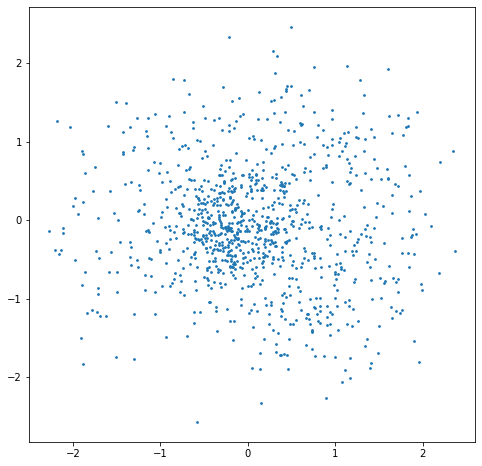

In [129]:
x0 = euler_maruyama_sampler(model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size=1000, num_steps=10, eps=1e-4, device=args.device)
plt.figure(figsize=(8, 8))
plt.scatter(x0[:, 0], x0[:, 1], s=3)
plt.show()

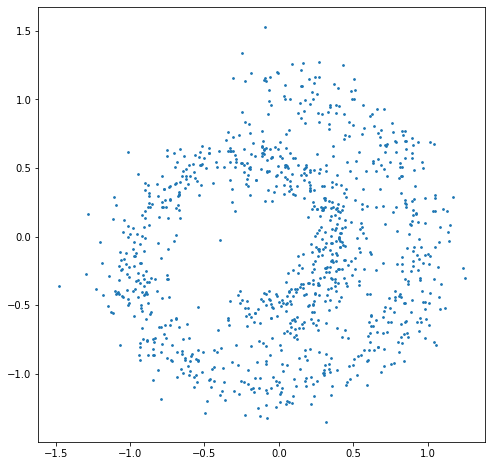

In [130]:
x0 = euler_maruyama_sampler(model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size=1000, num_steps=100, eps=1e-4, device=args.device)
plt.figure(figsize=(8, 8))
plt.scatter(x0[:, 0], x0[:, 1], s=3)
plt.show()

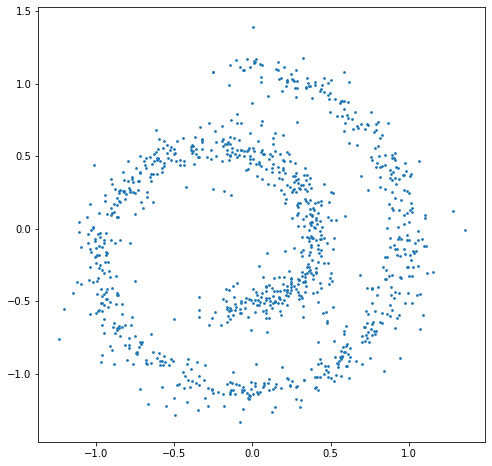

In [131]:
x0 = euler_maruyama_sampler(model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size=1000, num_steps=1000, eps=1e-4, device=args.device)
plt.figure(figsize=(8, 8))
plt.scatter(x0[:, 0], x0[:, 1], s=3)
plt.show()

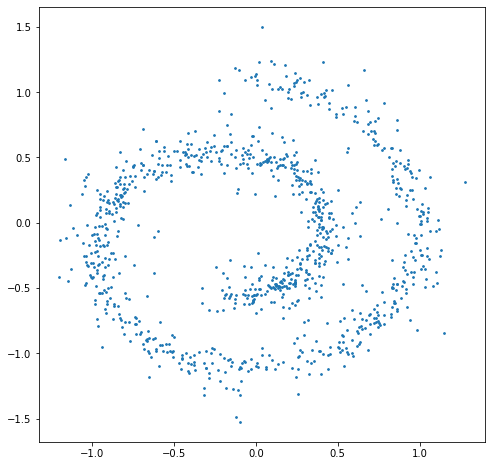

In [132]:
x0 = euler_maruyama_sampler(model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size=1000, num_steps=10000, eps=1e-4, device=args.device)
plt.figure(figsize=(8, 8))
plt.scatter(x0[:, 0], x0[:, 1], s=3)
plt.show()